<div style="text-align: center;">
    <h1> <font style="bold"> Ejercicio de Optimización de Recomendaciones de Productos para Quilmes </font></h1>
    <h2><font style="bold">Test Técnico: Análisis Exploratorio </font></h2>
    <h3><font style="bold">Abril Noguera</font></h3>
</div>

Este notebook se centra en el **análisis exploratorio** de la información obtenida para entender las tendencias, patrones y posibles irregularidades en los datos de ventas, con el objetivo de optimizar las estrategias de recomendación y asegurar que se alineen con las metas y restricciones comerciales del área de ventas.

## Descripción del Problema

El desafío consiste en ajustar las recomendaciones de productos de Quilmes bajo las siguientes restricciones:
1. Ningún producto debe tener más de 200% de recomendaciones en comparación con sus compradores del último mes, ni menos del 75%.
2. El segmento premium debe tener al menos un 20% de las recomendaciones totales.
3. El producto "Brahma Dorada-1 Lts-Bottle-RET" debe tener al menos 200 clientes con recomendación.

## Metodología

Para abordar este problema, se realizará lo siguiente:
1. **Análisis Exploratorio de Datos (EDA)**: Inspección y limpieza de los datos para entender la estructura y las características clave.
2. **Aplicación de Restricciones**: Implementación de las restricciones para ajustar los objetivos de recomendación.
3. **Análisis de Impacto**: Evaluación del impacto de los ajustes en las recomendaciones generales y en segmentos específicos.

## Implementación

In [282]:
# Importación de librerías
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from unidecode import unidecode
import re
import matplotlib.pyplot as plt
import seaborn as sns
import circlify
import scipy.stats as stats

In [283]:
# Configuración para visualización de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [284]:
# Configurar Matplotlib para mostrar gráficos en el notebook
%matplotlib inline

# Configuraciones de estilo de Seaborn para un look minimalista
sns.set(style="whitegrid")

### Análisis Exploratorio de Datos (EDA)

**Objetivo**: El propósito de esta sección es realizar un análisis preliminar de los datos proporcionados. Se busca identificar patrones, inconsistencias, valores faltantes y obtener una comprensión general de los datos con los que trabajaremos.

**Procedimiento**: Empezaremos importando los datos y realizando una inspección inicial para comprender su estructura y composición. Posteriormente, analizaremos estadísticas descriptivas, distribuciones y posibles correlaciones entre las variables. Este paso es crucial para asegurar la calidad de los datos antes de aplicar cualquier ajuste basado en las restricciones del problema.

In [285]:
# Carga de Base de Datos
df = pd.read_excel('data_ejercicio.xlsx', sheet_name='recommendations')
df1 = pd.read_excel('data_ejercicio.xlsx', sheet_name='customers_last_month')
df2 = pd.read_excel('data_ejercicio.xlsx', sheet_name='products')

In [286]:
len(df)

6399

Se une las recomendaciones con los detalles del producto.

In [287]:
# Identificar que los duplicados de la base de productos solo varien en el sku
print("Cantidad de productos recomendados: ",df['product_desc'].nunique())
print("Cantidad de productos descritos: ", len(df2.groupby(['product_desc','brand_family', 'brand', 'pack', 'brand_segment_I'])))

Cantidad de productos recomendados:  117
Cantidad de productos descritos:  117


In [288]:
# Se eliminan los duplicados de sku, ya que no aportan información
df2 = df2.drop_duplicates(subset=['product_desc'])
df2 = df2.drop(['sku_id'], axis=1)

In [289]:
# Agrego los detalles de los productos recomendados
df = pd.merge(df, df2, how='left', on='product_desc')

In [290]:
# Inspección inicial de los datos
df.head()

,customer_id,product_desc,ranking,brand_family,brand,pack,brand_segment_I
0,122053,Brahma-1 Lts-Bottle-RET,1,Brahma,Brahma,1 Lts-Bottle-RET,Core
1,122053,Brahma-1/2 Lts-Cans,2,Brahma,Brahma,1/2 Lts-Cans,Core
2,139102,Stella artois Noire-1/2 Lts-Cans,1,Stella Artois,Stella artois Noire,1/2 Lts-Cans,Premium
3,139102,Quilmes Bajo Cero-1 Lts-Bottle-RET,2,Quilmes Bajo Cero,Quilmes Bajo Cero,1 Lts-Bottle-RET,Value
4,139102,Stella artois-1/2 Lts-Cans,3,Stella Artois,Stella artois,1/2 Lts-Cans,Premium


Columnas:
- *customer_id*: Número de identificación del cliente.
- *product_desc*: Descripción del producto (Marca-Litros-Formato).
- *ranking*: Ranking de recomendación de cada producto para cada cliente.
- *brand_family*: Marca de cerveza.
- *brand*: Marca y producto especifico.
- *pack*: Descripción del tamaño y envase.
- *brand_segment_I*: segmento de recomendación del producto.

In [291]:
# Division de la descripción del producto en columnas: Marca, Litros y Formato
temp_df = df['product_desc'].str.split('-', expand=True)

In [292]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6399 entries, 0 to 6398
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       6399 non-null   object
 1   1       6399 non-null   object
 2   2       6399 non-null   object
 3   3       2585 non-null   object
dtypes: object(4)
memory usage: 200.1+ KB


La division no tiene nulos en las primeras 3 partes. La segunda característica del formato es especifica para algunos envases.

In [293]:
df['litros'] = temp_df[1]
df['formato'] = temp_df[2].str.cat(temp_df[3], sep=' ', na_rep='')

# Eliminar espacios en blanco al principio y al final de las cadenas de texto
df['formato'] = df['formato'].apply(lambda col: col.strip())

In [294]:
# Información de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6399 entries, 0 to 6398
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      6399 non-null   int64 
 1   product_desc     6399 non-null   object
 2   ranking          6399 non-null   int64 
 3   brand_family     6399 non-null   object
 4   brand            6399 non-null   object
 5   pack             6399 non-null   object
 6   brand_segment_I  6399 non-null   object
 7   litros           6399 non-null   object
 8   formato          6399 non-null   object
dtypes: int64(2), object(7)
memory usage: 450.1+ KB


In [295]:
# Descripción de los datos
df.describe()

,customer_id,ranking
count,6399.000000,6399.000000
mean,419659.135646,3.918737
std,113819.456889,2.676579
min,59564.000000,1.000000
25%,395109.500000,2.000000
50%,434493.000000,3.000000
75%,456249.000000,5.000000
max,695989.000000,12.000000


In [296]:
# Cambio de tipo de datos a texto para que sea reconocido por el Profile Report
df['brand_family'] = df['brand_family'].astype(str)
df['brand'] = df['brand'].astype(str)

In [297]:
# Profile Report
profile = ProfileReport(df, title="Informe Exploratorio", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### 📝 Conclusiones:

- **Análisis de Clientes**: Se presentan 1247 clientes distintos. Se debe analizar la proporción de recomendaciones que se le hacen a cada uno de los clientes.
- **Análisis de Ratings**: Los ratings van de 1 a 12, pero la mayoría de los ratings se dan para los primeros puestos.
- **Análisis de Variable Marca**: La variable brand podría contener valores repetidos que se están tomando como valores distintos aunque representan lo mismo. Analizar y procesar variables según mayúsculas, tildes y espacios. Además, se podría analizar la jerarquía entre la family brand y el producto especifico.
- **Análisis de Variable Litros**: La variable litros se presenta como texto, pero se podría procesar como una variable numérica. La variable este desbalanceada siendo el 51.7% de 1/2 litro. Se deben analizar outliers ya que hay pocos registros de muy gran tamaño.
- **Análisis de Variable Formato**: Hay 3 tipos de envases lata, botella y barril. La botella tiene dos tipos distintos RET y OW. Por lo que hay 4 valores únicos.
- **Análisis de Segmentos**
- **Relación entre Variables**: Los litros y el formato podrían tener una relación ya que dependiendo del envase el tamaño que podrá tomar. Al haber menos datos de barriles se entiende que los haya menos valores grandes en litros.
- **Análisis de Clientes Ultimo Mes**: Se analizara la repercusión que se obtuvo en las compras de cada producto.

#### Análisis de Clientes y Ratings:

Es necesario comprender cómo se distribuyen las recomendaciones a lo largo de nuestra base de clientes. Este análisis brinda perspectivas valiosas sobre el alcance y la efectividad de nuestras estrategias de recomendación.

In [298]:
color_barras = "#365CDF"
color_fondo = "#EEEFF0"
color_texto = "#000000"

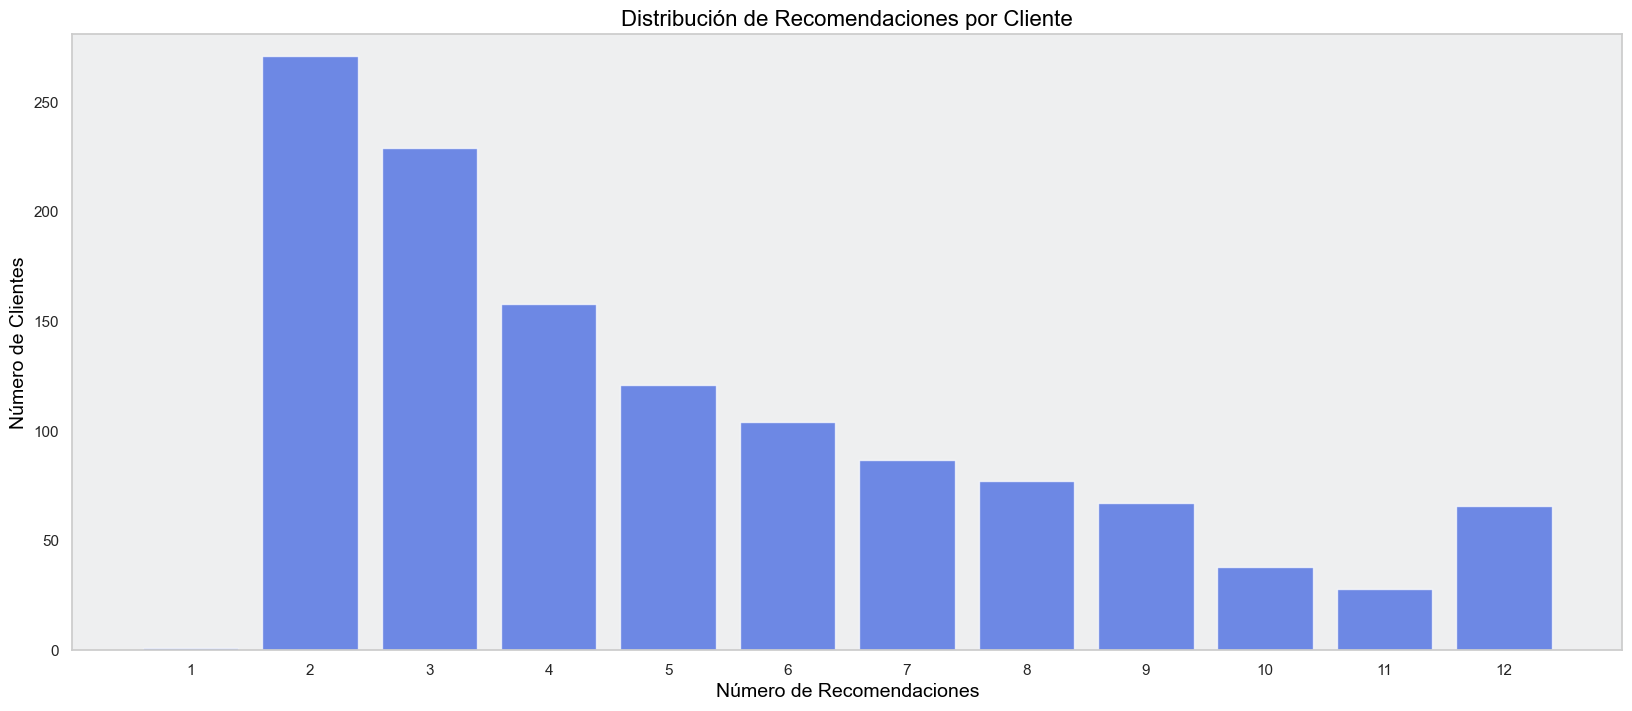

In [299]:
# Contar recomendaciones por cliente
conteo_recomendaciones = df.groupby('customer_id')['ranking'].count()

# Calcular la frecuencia de cada cantidad de recomendaciones
frecuencias = conteo_recomendaciones.value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(20, 8))
plt.bar(frecuencias.index, frecuencias.values, color=color_barras, alpha=0.7)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Ajustar los ticks en el eje x para que muestren todas las cantidades de recomendaciones
plt.xticks(frecuencias.index)

# Establecer el título y las etiquetas con los colores correspondientes
plt.title('Distribución de Recomendaciones por Cliente', fontsize=16, color=color_texto)
plt.xlabel('Número de Recomendaciones', fontsize=14, color=color_texto)
plt.ylabel('Número de Clientes', fontsize=14, color=color_texto)

# Ajustar límites del eje y si es necesario para mejorar la visualización
plt.ylim(0, frecuencias.values.max() + 10)

# Mostrar el gráfico
plt.show()

In [300]:
# Calcular estadísticas de tendencia central
estadisticas_centrales = conteo_recomendaciones.agg(['mean', 'median', 'std', 'min', 'max', lambda x: x.mode().values[0]]).rename({'<lambda>': 'mode'})

# Imprimir estadísticas en un formato limpio
print(estadisticas_centrales.to_string())

mean       5.131516
median     4.000000
std        2.959929
min        1.000000
max       12.000000
mode       2.000000


- Pocos clientes reciben unicamente una recomendación, como mínimo se sugirieron dos y esta cantidad de recomendaciones es la más repetida.
- En promedio los clientes reciben 4 recomendaciones.
- El máximo de recomendaciones es de 12, pero son pocos los clientes que reciben más de 10 recomendaciones.

Además, se comprueba que por cada cliente al que se le hace recomendaciones no haya puestos vacíos. Es decir, si un cliente tiene una recomendación con ranking 3 si o si deberá tener recomendación con ranking 1 y 2.

In [301]:
# Paso 1: Obtener los rankings únicos en el DataFrame
rankings_unicos = df['ranking'].unique()

# Paso 2: Agrupar por 'customer_id' y obtener todos los 'ranking' para cada cliente
clientes_rankings = df.groupby('customer_id')['ranking'].apply(set).reset_index()

# Paso 3: Verificar si para cada cliente los rankings son consecutivos desde 1 hasta su máximo
def verificacion_consecutiva(rankings_cliente):
    return set(range(1, max(rankings_cliente) + 1)) == rankings_cliente

# Aplicar la verificación a cada cliente
clientes_rankings['verificacion'] = clientes_rankings['ranking'].apply(verificacion_consecutiva)

# Filtrar aquellos clientes que no cumplen con la condición
clientes_incompletos = clientes_rankings[~clientes_rankings['verificacion']]

# Mostrar los clientes que no cumplen con la condición
if(len(clientes_incompletos) > 0):
    print(clientes_incompletos[['customer_id', 'ranking']])
else:
    print('Todos los clientes tienen rankings consecutivos desde 1 hasta su máximo')

Todos los clientes tienen rankings consecutivos desde 1 hasta su máximo


✅ Se cumple esta verificación!

#### Análisis de Marca:

Para procesar la variable que contiene los nombres de las marcas y productos de cerveza se debe:
1. Identificar Marcas y Productos: Si las marcas tienen un conjunto de nombres conocidos, podrías usar eso para identificar y separar la marca del resto del producto.
2. Crear Nuevas Variables: Basándote en la estructura de los nombres, podrías crear nuevas variables para 'marca' y 'producto'. Para nombres que solo tienen la marca, el producto podría estar vacío o tener un valor predeterminado como 'General'.

In [302]:
# Análisis de Valores Únicos de la Variable Marca
print(df['brand'].unique())
print(df['brand_family'].unique())

['Brahma' 'Stella artois Noire' 'Quilmes Bajo Cero' 'Stella artois'
 'Patagonia Amber Lager' 'Goose Island Hazy' 'Temple Scottish'
 'Andes Origen Fresquita' 'Quilmes Clasica' 'Stella Artois Blanche'
 'Corona' 'Brahma Dorada' 'Quilmes 0.0' 'Budweiser'
 'Patagonia Bohemian Pilsener' 'Quilmes Ipa' 'Michelob Ultra' 'Andes'
 'Andes Origen Roja' 'Andes Origen IPA' '27 Eazy' '1890'
 'Patagonia Vera Ipa' 'Andes Origen Negra' 'Patagonia 24.7' 'Temple Wolf'
 'Quilmes Stout' 'Andes Origen Rubia' 'Patagonia Indira' 'Quilmes Bock'
 'Patagonia Hoppy Lager' 'Patagonia Weisse' 'Stella artois 0.0%'
 'Patagonia Travesia' 'Goose Island' 'Andes Origen Criolla'
 'Andes Origen IPA Roja' 'Temple Honey' 'Quilmes Red Lager'
 'Patagonia Solcitra' 'Patagonia abrazo oso' 'Quilmes Doble'
 'Andes Origen Vendimia' 'Temple Golden' 'Temple Cosmica' 'Patagonia Kune'
 'Patagonia Old Ale']
['Brahma' 'Stella Artois' 'Quilmes Bajo Cero' 'Patagonia' 'Goose Island'
 'Temple' 'Andes Origen' 'Quilmes' 'Corona' 'Quilmes 0.0' 'B

In [303]:
# Procesamiento de la Variable Marca
df.loc[df['brand_family'] == 'Quilmes Variedades ', 'brand_family'] = 'Quilmes'
df.loc[df['brand_family'] == 'Andes', 'brand_family'] = 'Andes Origen'
df.loc[df['brand'] == 'Andes', 'brand'] = 'Andes Origen'

In [304]:
# Definición de marcas conocidas
marcas_conocidas = df['brand_family'].unique()
marcas_conocidas = sorted(marcas_conocidas, key=len, reverse=True)

In [305]:
# Función para identificar la marca y el producto
def identificar_producto(nombre):
    for marca in marcas_conocidas:
        if nombre.startswith(marca):
            # El resto de la cadena después del nombre de la marca sería el producto
            producto = nombre[len(marca):].strip()
            return marca, producto if producto else 'Clasica'
    return 'desconocida', nombre

In [306]:
# Crear nuevas columnas  'producto' en el DataFrame
_, df['producto'] = zip(*df['brand'].apply(identificar_producto))

In [307]:
# Verificar los resultados
print(df[['brand_family', 'producto']].head())

        brand_family             producto
0             Brahma              Clasica
1             Brahma              Clasica
2      Stella Artois  Stella artois Noire
3  Quilmes Bajo Cero              Clasica
4      Stella Artois        Stella artois


In [308]:
# Preparar los datos para el gráfico de Circle Packing
data = df.groupby(['brand_family', 'brand']).size().reset_index(name='frecuencia')

# Agrupar y sumar las frecuencias por brand_family y producto
grouped_data = data.groupby(['brand_family', 'brand'])['frecuencia'].sum().reset_index()

# Crear una estructura de datos para almacenar la jerarquía
result = [{'id': 'Cervezas', 'datum': grouped_data['frecuencia'].sum(), 'children': []}]

# Iterar a través de las marcas y crear la jerarquía
for marca in grouped_data['brand_family'].unique():
    marca_data = grouped_data[grouped_data['brand_family'] == marca]
    marca_entry = {'id': marca, 'datum': marca_data['frecuencia'].sum(), 'children': []}

    for _, row in marca_data.iterrows():
        producto_entry = {'id': row['brand'], 'datum': row['frecuencia']}
        marca_entry['children'].append(producto_entry)

    result[0]['children'].append(marca_entry)

# Mostrar el resultado
print(result)

[{'id': 'Cervezas', 'datum': 6399, 'children': [{'id': '1890', 'datum': 100, 'children': [{'id': '1890', 'datum': 100}]}, {'id': '27 Eazy', 'datum': 19, 'children': [{'id': '27 Eazy', 'datum': 19}]}, {'id': 'Andes Origen', 'datum': 1106, 'children': [{'id': 'Andes Origen', 'datum': 4}, {'id': 'Andes Origen Criolla', 'datum': 5}, {'id': 'Andes Origen Fresquita', 'datum': 418}, {'id': 'Andes Origen IPA', 'datum': 207}, {'id': 'Andes Origen IPA Roja', 'datum': 27}, {'id': 'Andes Origen Negra', 'datum': 41}, {'id': 'Andes Origen Roja', 'datum': 221}, {'id': 'Andes Origen Rubia', 'datum': 175}, {'id': 'Andes Origen Vendimia', 'datum': 8}]}, {'id': 'Brahma', 'datum': 1632, 'children': [{'id': 'Brahma', 'datum': 957}, {'id': 'Brahma Dorada', 'datum': 675}]}, {'id': 'Budweiser', 'datum': 485, 'children': [{'id': 'Budweiser', 'datum': 485}]}, {'id': 'Corona', 'datum': 594, 'children': [{'id': 'Corona', 'datum': 594}]}, {'id': 'Goose Island', 'datum': 16, 'children': [{'id': 'Goose Island', 'dat

In [309]:
# Computar las posiciones de los círculos
circles = circlify.circlify(
    result, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

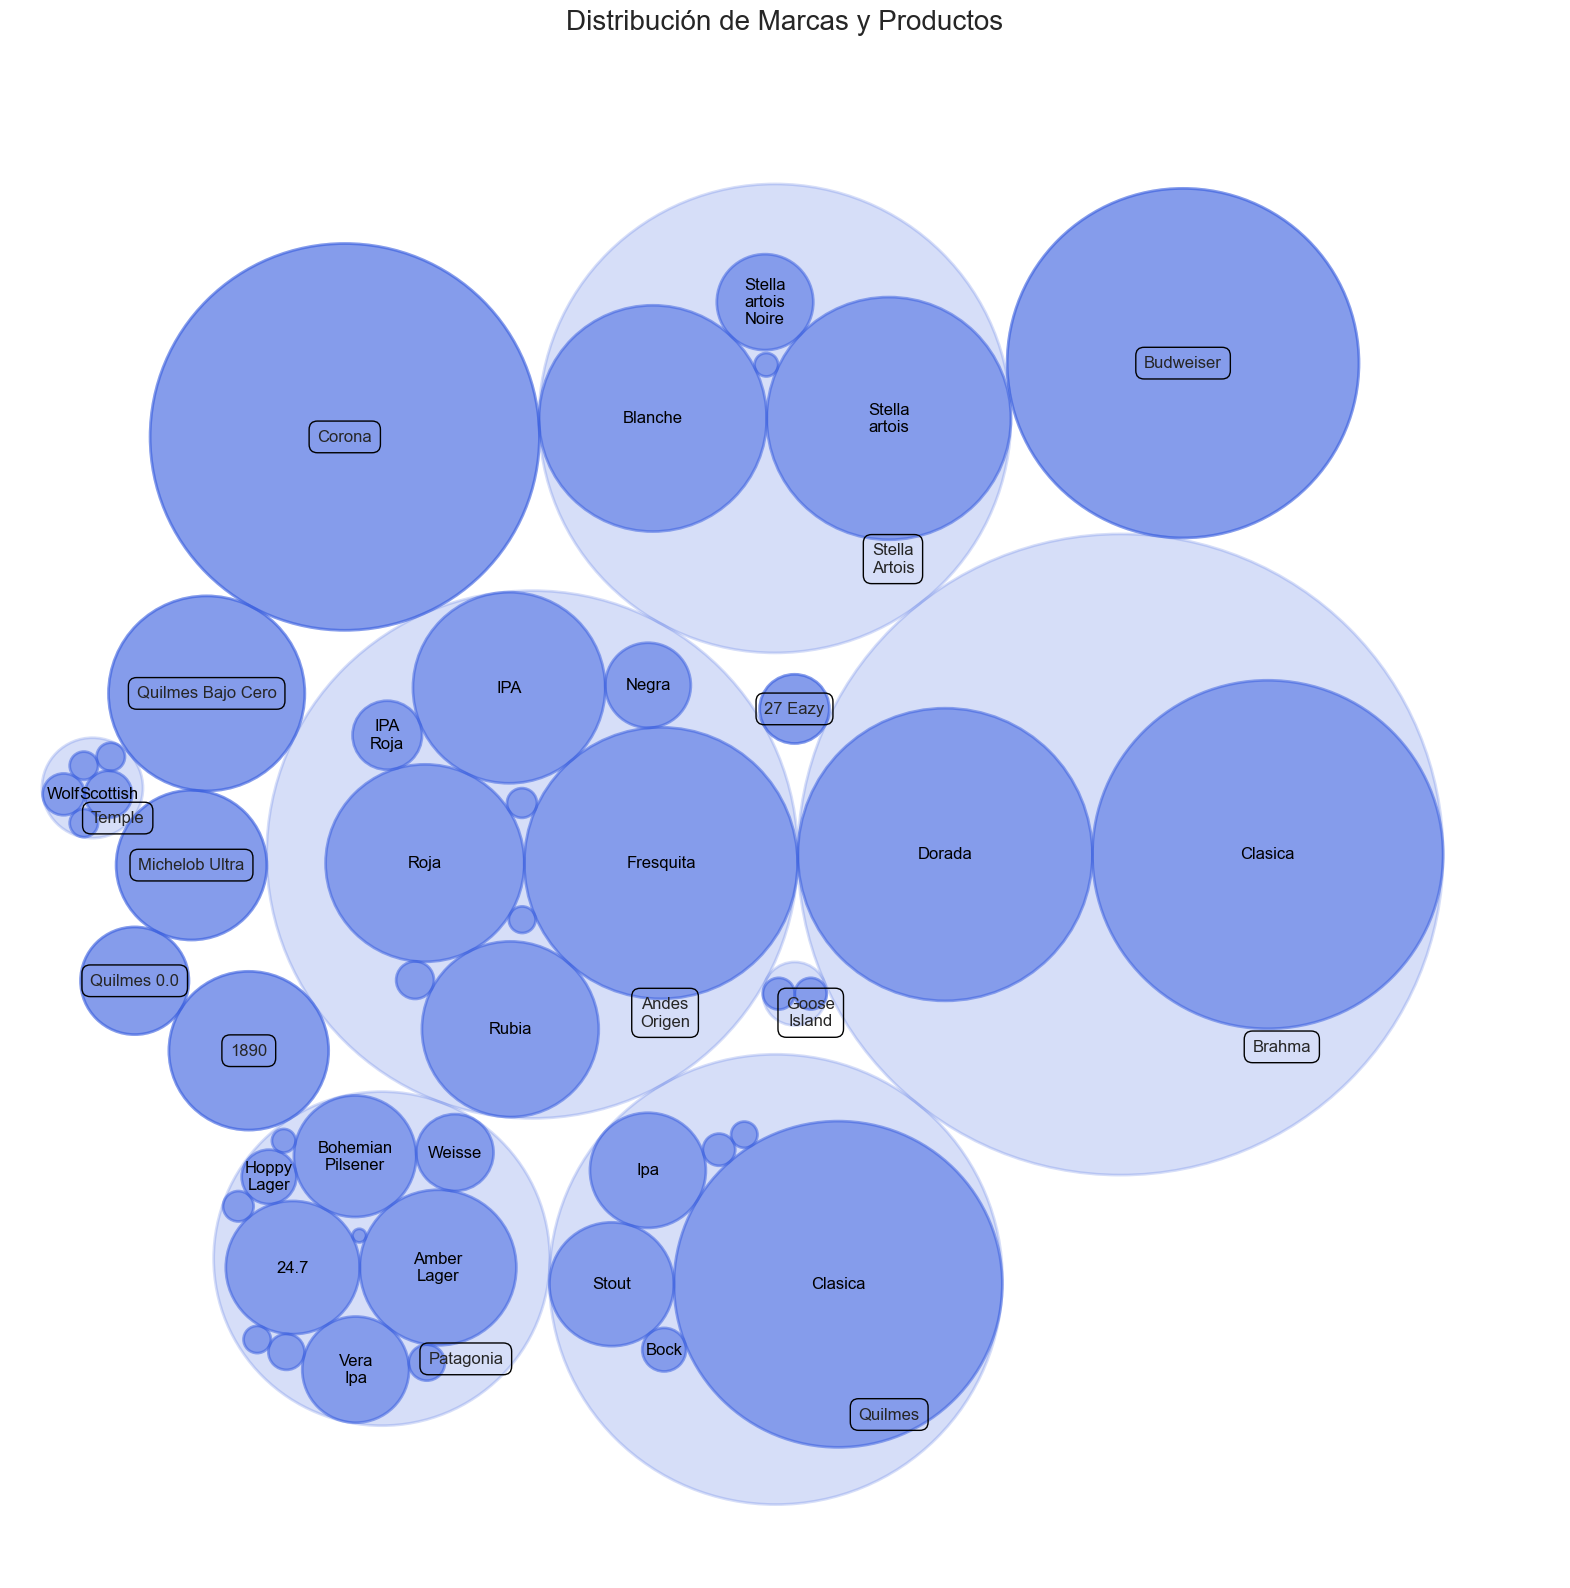

In [310]:
# Crear la figura
fig, ax = plt.subplots(figsize=(20,20))

# Título
ax.set_title('Distribución de Marcas y Productos', fontsize=20)

# Eliminar ejes
ax.axis('off')

# Encontrar limites en los ejes
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Filtra los productos con frecuencia baja frecuencia o poca diversidad.
productos_filtrados = data[data['frecuencia'] >= 10]
marcas_filtradas = data.groupby('brand_family').size().reset_index(name='frecuencia')
marcas_filtradas = marcas_filtradas.loc[marcas_filtradas['frecuencia'] == 1,'brand_family'].to_list()

# Imprimir círculos de mayor nivel
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color_barras))

# Imprimir círculos y etiquetas de productos con frecuencia mayor o igual a 10
for circle in circles:
    if circle.level != 3:
        continue
    x, y, r = circle
    parent, label = identificar_producto(circle.ex["id"])
    ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2, color=color_barras))

    # Verifica si el producto está en la lista de productos filtrados
    if (circle.ex["id"] in productos_filtrados['brand'].values) & (parent not in marcas_filtradas):
        if ' ' in label:
            label = label.replace(' ', '\n')
        plt.annotate(label, (x, y),va='center', ha='center', color=color_texto)


# Imprimir etiquetas para círculos de marcas
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    if label in marcas_filtradas:
        plt.annotate(label, (x, y) ,va='center', ha='center', bbox=dict(facecolor='none', edgecolor=color_texto, boxstyle='round', pad=0.5))
    else:
        if ' ' in label:
                label = label.replace(' ', '\n')
        plt.annotate(label, (x + 0.5 * r , y - 0.6 * r ) ,va='center', ha='center', bbox=dict(facecolor='none', edgecolor=color_texto, boxstyle='round', pad=0.5))


- Las marcas con mas presencia son mas diversas en sus productos. Excepto corona y budweiser que solo presentan su producto clasico.
- De misma forma, las marcas menos recomendadas no tienen mucha diversidad en sus productos. Exceptuando temple que tiene 5 tipos..
- La mayoría de las marcas presentan una categoría o tipo de producto clasico.
- La brahma es la cerveza mas recomendada.

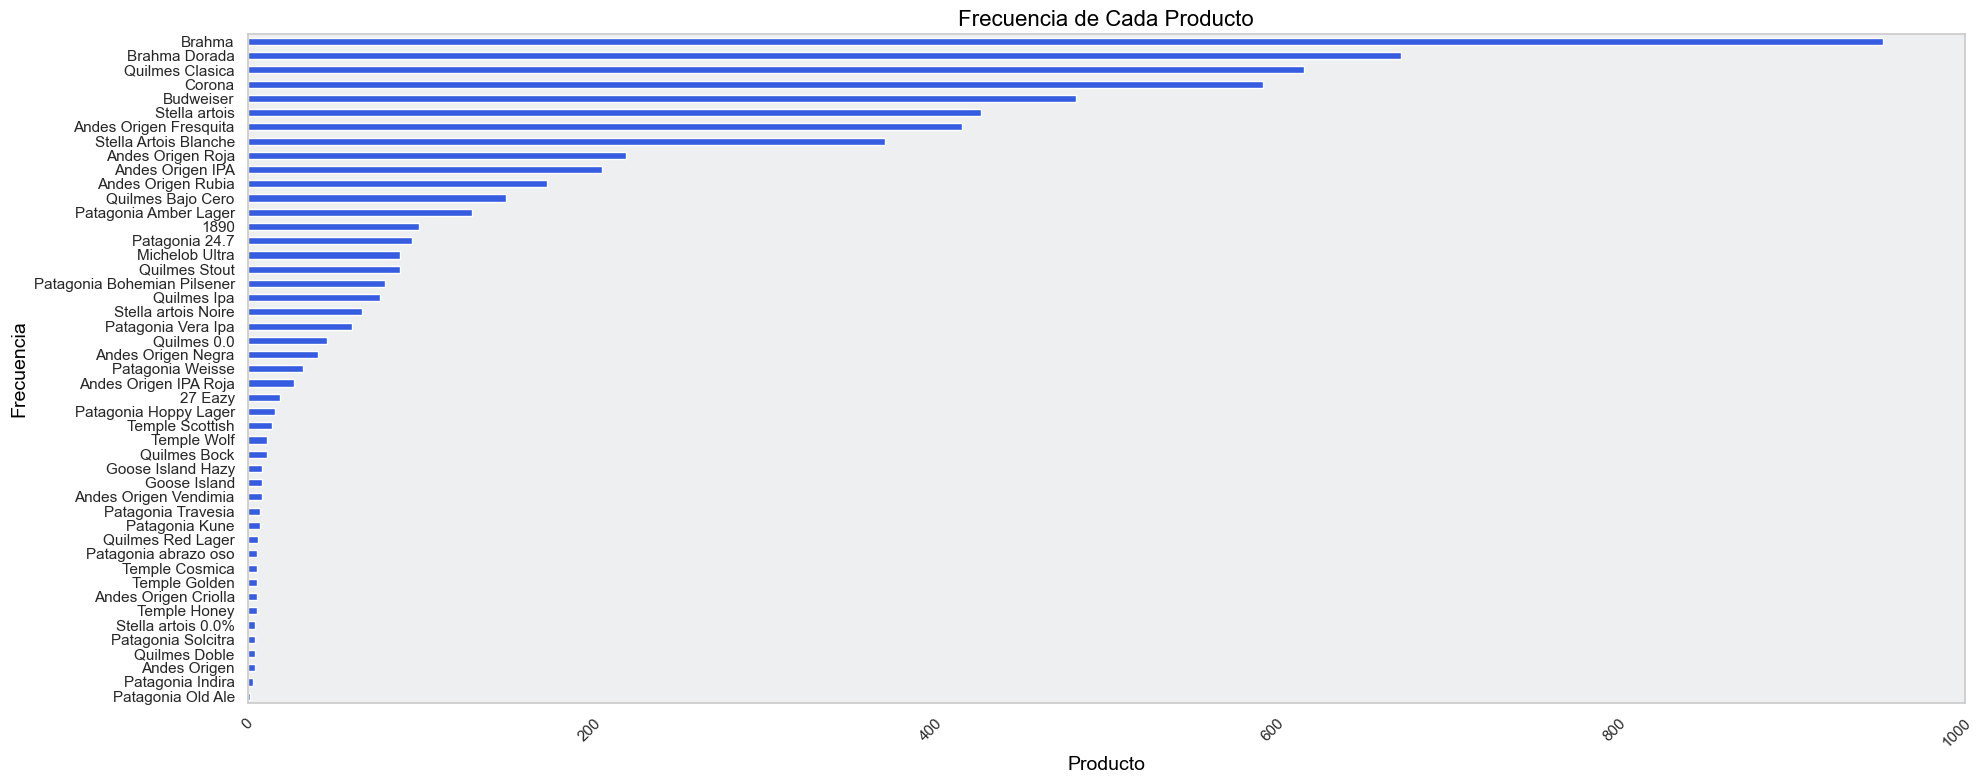

In [311]:
frecuencias_productos = df['brand'].value_counts().sort_values(ascending=True)

# Crear el gráfico de barras
plt.figure(figsize=(20, 8))
frecuencias_productos.plot(kind='barh', color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Ajustar las etiquetas y el título con los colores correspondientes
plt.title('Frecuencia de Cada Producto', fontsize=16, color=color_texto)
plt.xlabel('Producto', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)

# Rotar las etiquetas del eje x para mejor legibilidad si es necesario
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Se recomienda en mayor proporción la cerveza de Brahma, en segundo lugar la brahma dorada que es el producto estrella de la compañia.

#### Análisis de Litros

In [312]:
# Análisis de Valores Únicos de la Variable Litros
print(df['litros'].unique())

['1 Lts' '1/2 Lts' '20 Lts' '30 Lts' '3/4 Lts' '1/3 Lts' '1/4 Lts'
 '50 Lts' '2/3 Lts' '20000 Lts' '1.2 Lts']


In [313]:
# Función que convierte las fracciones y decimales a litros
def convertir_litros(valor):
    # Si el valor contiene una barra, asumimos que es una fracción
    if '/' in valor:
        fraccion = valor.split()[0]  # Obtenemos solo la fracción, sin 'lts'
        numerador, denominador = fraccion.split('/')
        return float(numerador) / float(denominador)
    # Si no, simplemente eliminamos el texto y convertimos a float
    else:
        return float(valor.split()[0])

In [314]:
# Aplicamos la función a la columna 'litros'
df['ltrs'] = df['litros'].apply(convertir_litros)

In [315]:
df['ltrs'].head()

0    1.0
1    0.5
2    0.5
3    1.0
4    0.5
Name: ltrs, dtype: float64

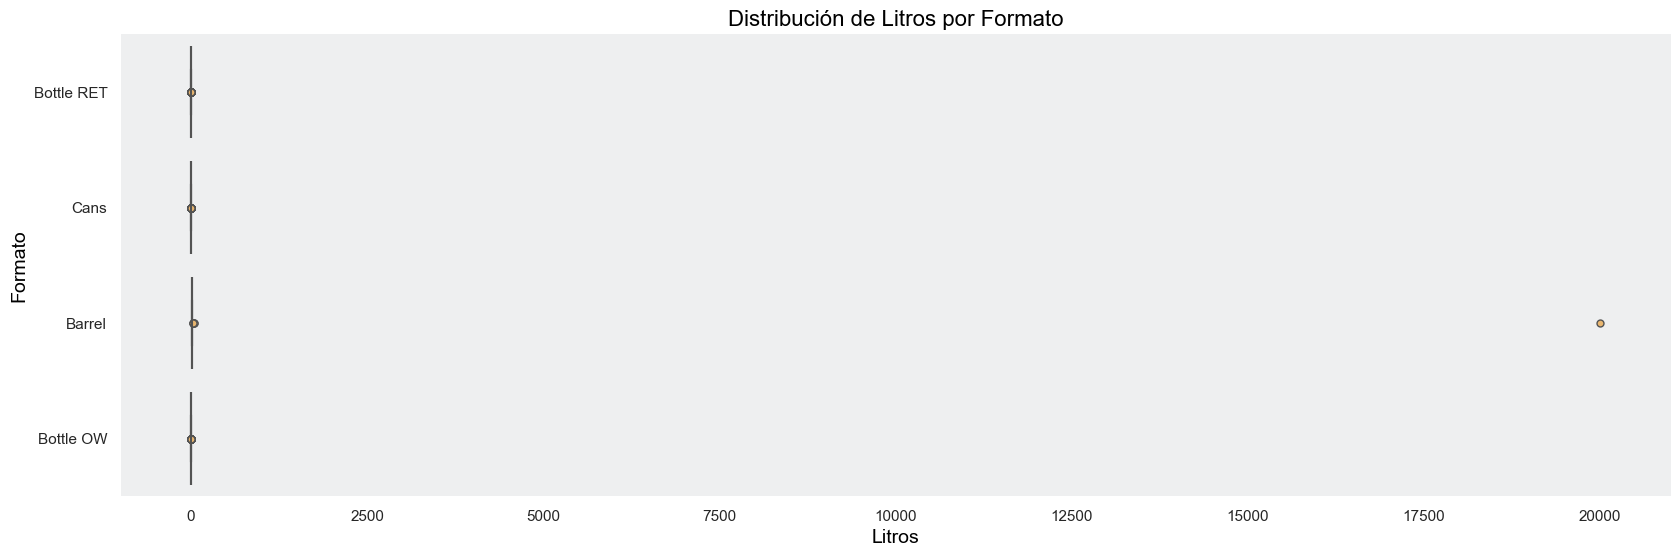

In [316]:
# Establecer el tamaño de la figura (ancho, alto) para hacer el gráfico más ancho
fig, ax = plt.subplots(figsize=(20, 6))

# Crear el boxplot dividido por 'formato'
sns.boxplot(x='ltrs', y='formato', data=df, palette=["#365CDF"], flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))

# Configurar el color del fondo y desactivar la cuadrícula
ax.set_facecolor('#EEEFF0')
ax.grid(False)

# Eliminar el borde del eje
for spine in ax.spines.values():
    spine.set_visible(False)

# Establecer el título y las etiquetas con los colores correspondientes
ax.set_title('Distribución de Litros por Formato', fontsize=16, color='#000000')
ax.set_xlabel('Litros', fontsize=14, color='#000000')
ax.set_ylabel('Formato', fontsize=14, color='#000000')

# Mostrar el gráfico
plt.show()

Resulta que el valor de 20000 litros en la variable es atípico también para los barriles. Analizamos el registro:

In [317]:
# Registros con valores atípicos
df[df['ltrs'] == 20000]

,customer_id,product_desc,ranking,brand_family,brand,pack,brand_segment_I,litros,formato,producto,ltrs
3691,442587,Patagonia Travesia-20000 Lts-Barrel,9,Patagonia,Patagonia Travesia,20000 Lts-Barrel,Super Premium,20000 Lts,Barrel,Travesia,20000.0


In [318]:
# Eliminación de registros con valores atípicos
df = df[df['ltrs'] < 100]

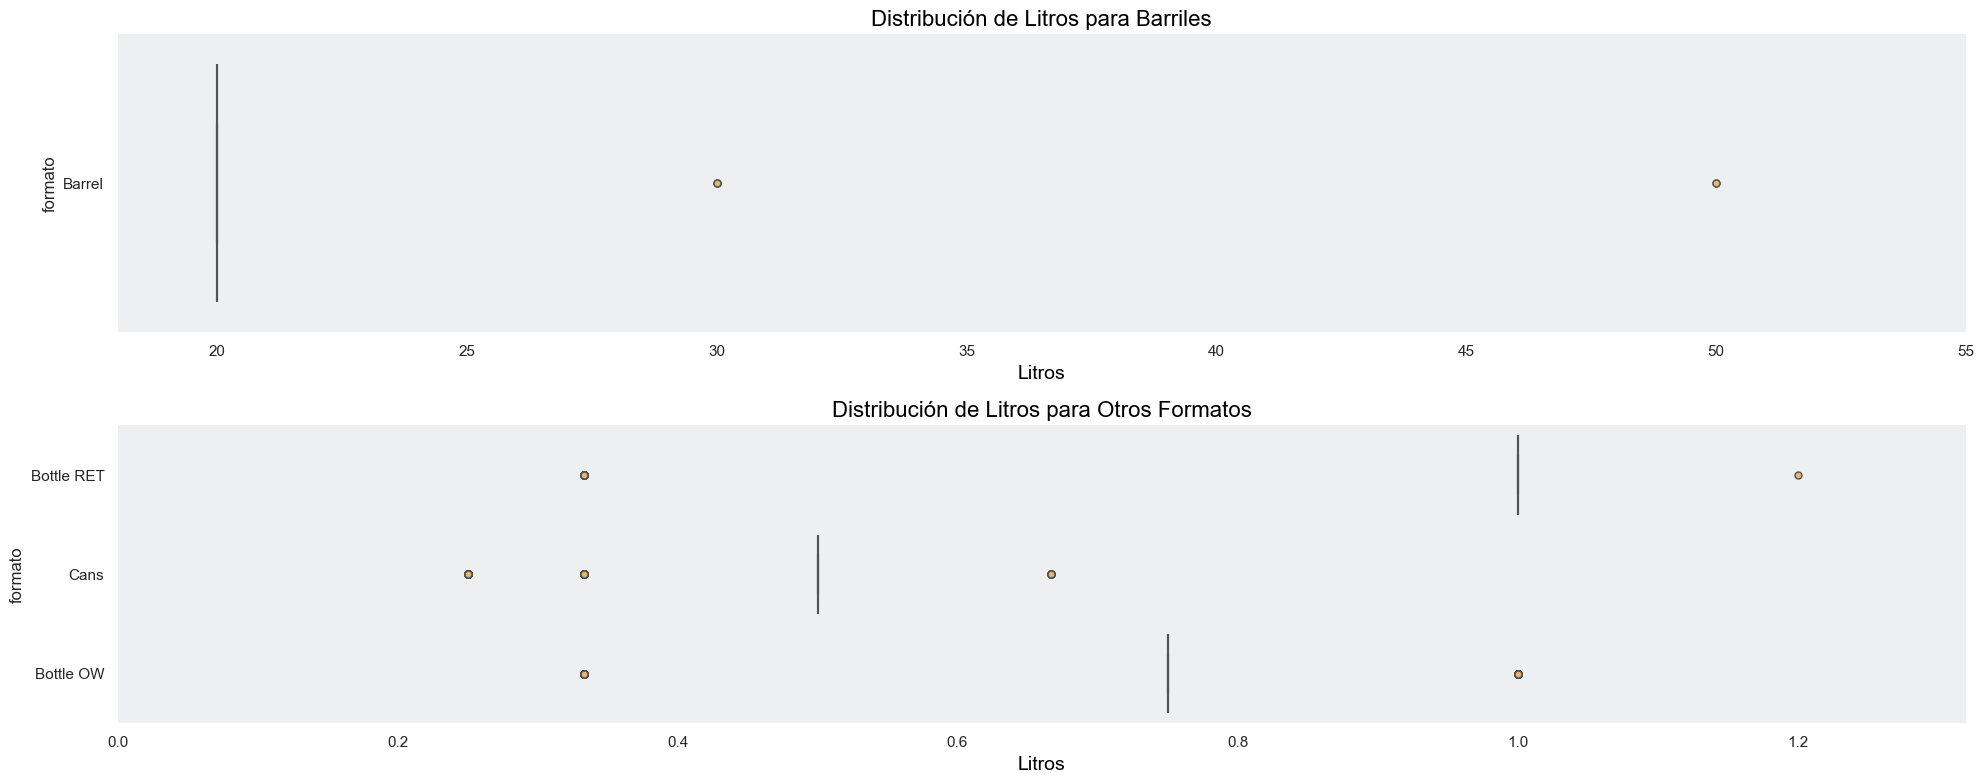

In [319]:
# Filtrar el DataFrame para 'Barrel'
df_barrel = df[df['formato'] == 'Barrel']
df_otros = df[df['formato'] != 'Barrel']

# Crear dos subplots, uno para 'Barrel' y otro para los demás formatos
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=False)

# Primer boxplot para 'Barrel'
sns.boxplot(x='ltrs', y='formato', data=df_barrel, ax=axs[0], color="#365CDF", flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))
axs[0].set_title('Distribución de Litros para Barriles', fontsize=16, color='#000000')
axs[0].set_facecolor('#EEEFF0')
axs[0].grid(False)
# Establecer los límites del eje x para 'barrel' basado en su rango de datos
axs[0].set_xlim(left=df_barrel['ltrs'].min() * 0.9, right=df_barrel['ltrs'].max() * 1.1)

# Segundo boxplot para los demás formatos
sns.boxplot(x='ltrs', y='formato', data=df_otros, ax=axs[1], color="#365CDF", flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))
axs[1].set_title('Distribución de Litros para Otros Formatos', fontsize=16, color='#000000')
axs[1].set_facecolor('#EEEFF0')
axs[1].grid(False)
# Establecer los límites del eje x para otros formatos basado en su rango de datos
axs[1].set_xlim(left=0, right=df_otros['ltrs'].max() * 1.1)

# Eliminar los bordes de los ejes
for ax in axs:
    for spine in ax.spines.values():
        spine.set_visible(False)

# Establecer las etiquetas de los ejes x
for ax in axs:
    ax.set_xlabel('Litros', fontsize=14, color='#000000')

# Ajustar el layout para evitar la superposición de los títulos de los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En todos los tipos de envases hay una medida más recomendada. Pero en algunos casos se sugieren otras medidas. Estos casos no se toman como outliers ya que sugieren tamaños posibles para el envase.

In [320]:
# Agrupar por 'formato' y calcular las estadísticas de tendencia central
estadisticas_tendencia_central = df.groupby('formato')['ltrs'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
modas = df.groupby('formato')['ltrs'].agg(lambda x: x.mode().tolist()).reset_index().rename(columns={'ltrs': 'mode'})

# Combinar las tablas de estadísticas y modas si es necesario
estadisticas_completas = pd.merge(estadisticas_tendencia_central, modas, on='formato')

# Mostrar la tabla
estadisticas_completas

,formato,mean,median,std,min,max,mode
0,Barrel,23.000000,20.00,7.943768,20.000000,50.000000,[20.0]
1,Bottle OW,0.668476,0.75,0.187970,0.333333,1.000000,[0.75]
2,Bottle RET,0.839247,1.00,0.285415,0.333333,1.200000,[1.0]
3,Cans,0.496123,0.50,0.031831,0.250000,0.666667,[0.5]


#### Análisis de Formato:

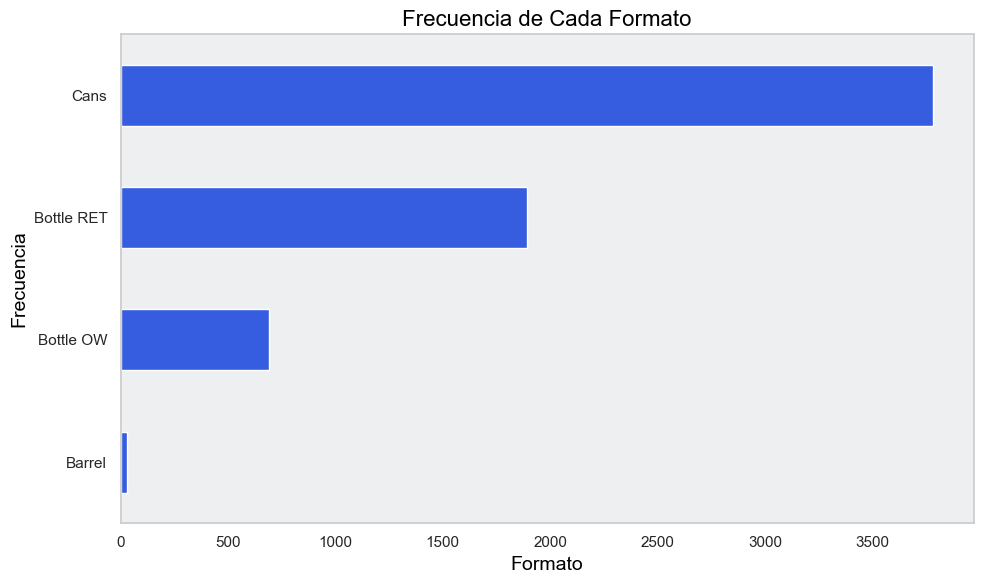

In [321]:
frecuencias_formatos = df['formato'].value_counts().sort_values(ascending=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
frecuencias_formatos.plot(kind='barh', color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Ajustar las etiquetas y el título con los colores correspondientes
plt.title('Frecuencia de Cada Formato', fontsize=16, color=color_texto)
plt.xlabel('Formato', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)


# Mostrar el gráfico
plt.tight_layout()
plt.show()

- Cans Predominantes: El formato 'cans' tiene la frecuencia más alta, sugiriendo que es el más común o popular entre los formatos disponibles.
- Segundo Lugar: 'bottle ret' es el segundo más frecuente, aunque con significativamente menos frecuencia que 'cans'.
- Menos Comunes: 'bottle ow' y 'barrel' aparecen con mucha menos frecuencia, indicando que son los menos comunes o quizás los más especializados o de nicho en esta selección de productos.

#### Análisis de Segmentos

Se analizan los segmentos de las marcas para explorar la distribución y características de estas segmentaciones. Asi se obtienen insights valiosos que puedan guiar nuestras decisiones de negocio.

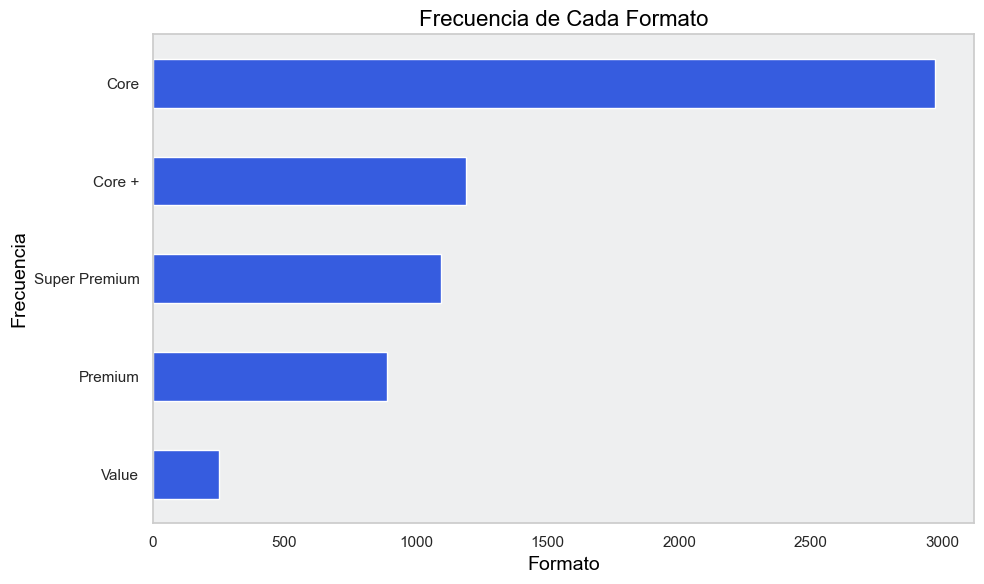

In [322]:
# Análisis de la frecuencia de cada segmento de marca
frecuencia_segmentos = df['brand_segment_I'].value_counts().sort_values(ascending=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
frecuencia_segmentos.plot(kind='barh', color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Ajustar las etiquetas y el título con los colores correspondientes
plt.title('Frecuencia de Cada Formato', fontsize=16, color=color_texto)
plt.xlabel('Formato', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)


# Mostrar el gráfico
plt.tight_layout()
plt.show()

- La mayoría de las recomendaciones se concentran en el segmento core.
- No hay muchas recomendaciones de productos de segmento value.

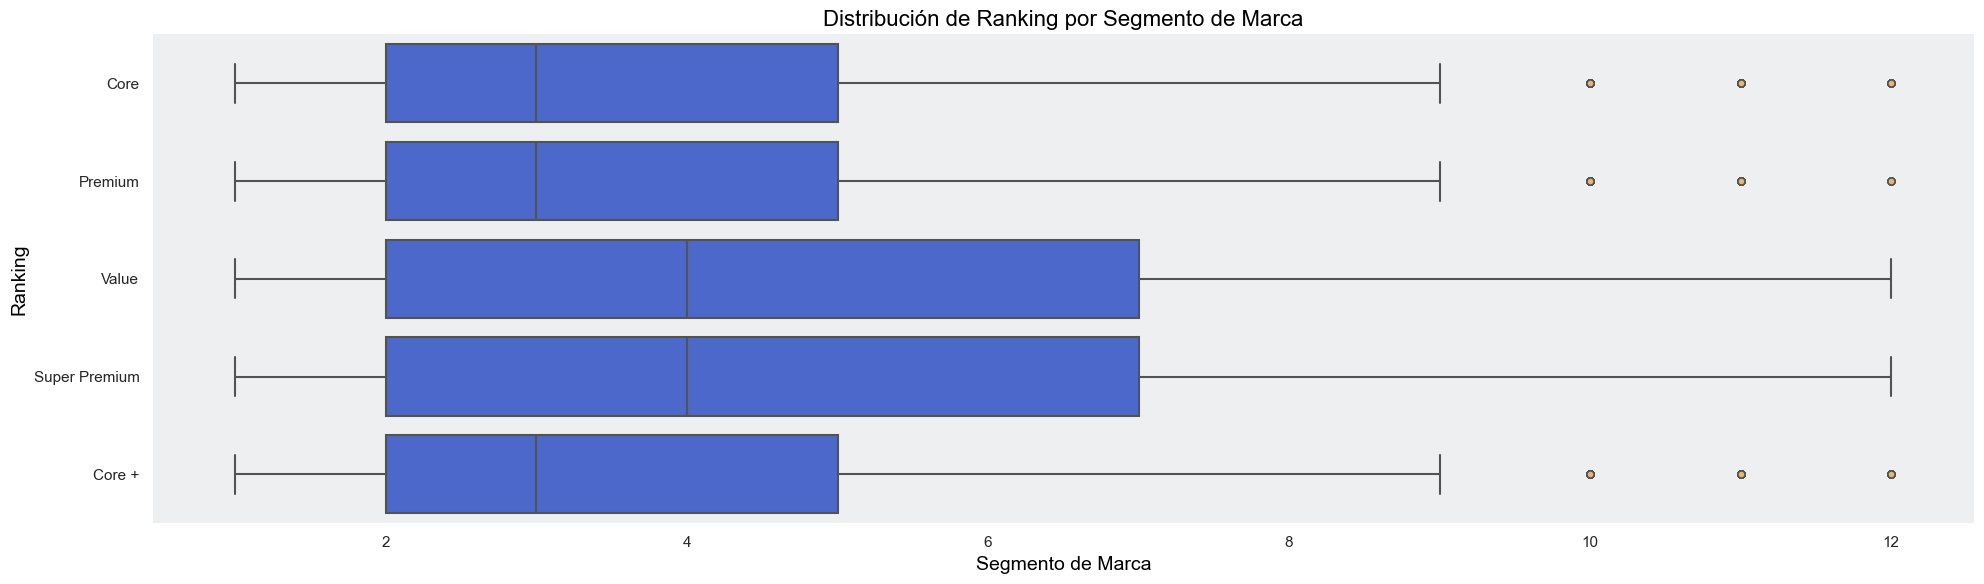

In [323]:
# Crear la figura
plt.figure(figsize=(20, 6))

# Crear boxplot 
sns.boxplot(y='brand_segment_I', x='ranking', data=df, color="#365CDF", flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))

# Establecer título, color de fondo y eliminar la cuadrícula
plt.title('Distribución de Ranking por Segmento de Marca', fontsize=16, color='#000000')
plt.gca().set_facecolor('#EEEFF0')
plt.grid(False)

# Establecer las etiquetas de los ejes
plt.xlabel('Segmento de Marca', fontsize=14, color='#000000')
plt.ylabel('Ranking', fontsize=14, color='#000000')

# Eliminar los bordes de los ejes
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()


- los segmentos value y super premium tienen amplia dispersion.
- Hay outliers en core, core + y premium, lo que podría señalar casos específicos donde estos productos se desvían de la tendencia común de recomendaciones.

#### Análisis de Compras Último Mes

Este análisis tiene como objetivo entender la relación entre la cantidad de clientes que compraron productos específicos el mes pasado y la cantidad de veces que esos productos fueron recomendados. Buscaremos patrones o correlaciones que puedan sugerir el impacto de las recomendaciones en las decisiones de compra de los clientes.

In [324]:
# Cantidad de recomendaciones por product_desc
conteo_recomendaciones = df.groupby('product_desc')['ranking'].count().reset_index(name='recomendaciones')

In [325]:
# Agrego la información de los productos recomendados, incluyendo los que no fueron comprados el ultimo mes (o no hay información al respecto)
df1 = df1.merge(conteo_recomendaciones, how='right', on='product_desc')

In [326]:
# Agrego los detalles de los productos recomendados
df1 = pd.merge(df1, df2, how='left', on='product_desc')

In [327]:
# Estadísticas descriptivas
print(df1[['customers_last_month', 'recomendaciones']].describe())

       customers_last_month  recomendaciones
count             71.000000       116.000000
mean              90.126761        55.155172
std               82.378036        96.040354
min                5.000000         1.000000
25%               25.500000         4.000000
50%               57.000000        15.500000
75%              148.500000        46.500000
max              354.000000       483.000000


- La cantidad de clientes que compraron productos el mes pasado tiene un rango amplio de 5 a 354.
- Las recomendaciones varían entre 3 y 483, indicando una gran diversidad en la frecuencia de recomendaciones.
- El promedio de clientes es ligeramente superior al promedio de recomendaciones, ambos rondando el valor de 90.
- Existe una mayor variabilidad en las recomendaciones en comparación con los clientes del último mes, según las desviaciones estándar.
- La mediana muestra que más de la mitad de los productos tiene menos de 57 clientes y menos de 40 recomendaciones.
- La distribución de ambas variables es asimétrica, con una tendencia hacia valores más bajos y algunos valores altos atípicos.
- El 75% de los productos tiene menos de 149 clientes y menos de 114 recomendaciones, lo que podría sugerir un enfoque en productos más populares o una revisión de las estrategias de recomendación.

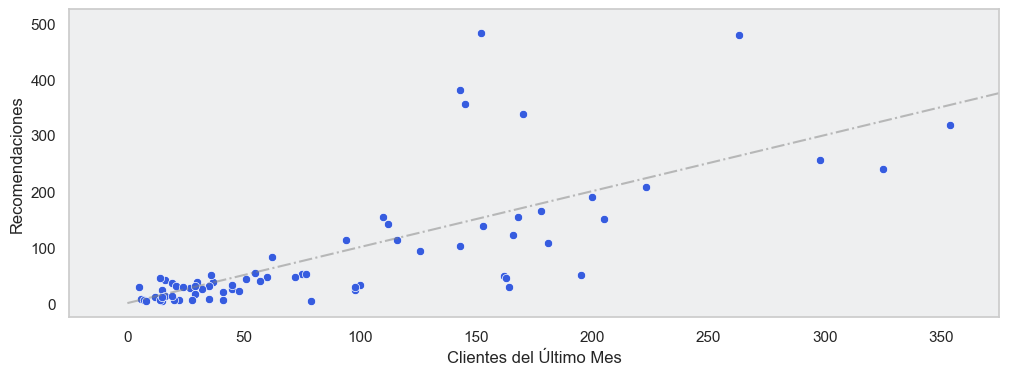

In [330]:
# Gráfico de dispersión para comparar las dos variables
plt.figure(figsize=(12, 4))
sns.scatterplot(x='customers_last_month', y='recomendaciones', data=df1, color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Añadir líneas punteadas
x = np.linspace(0, 500, 100)  # Crear un rango de valores para x
plt.plot(x, x, linestyle='-.', color='grey', label='y = x', alpha=0.5)  # Línea para y = x

plt.xlim(-25,375)

plt.xlabel('Clientes del Último Mes')
plt.ylabel('Recomendaciones')
plt.show()

- **Correspondencia entre Recomendaciones y Clientes**: Se logra ver una relación entre los resultados del algoritmo de recomendación y las compras reales.
- **Sobre Recomendación**: Algunos productos tienen muchos más recomendaciones que clientes, por lo que se estarían invirtiendo recursos innecesarios en esos productos.
- **Sub Recomendación**: De la misma forma en algunos casos hay menor recomendaciones que clientes.  
- **Frecuencia de Productos**: Hay puntos concentrados principalmente en el rango inferior, lo que indica una mayor frecuencia de productos con menos clientes y recomendaciones.

In [267]:
# Coeficiente de correlación
correlation = df1['customers_last_month'].corr(df1['recomendaciones'])
print(f"El coeficiente de correlación entre las compras del último mes y las recomendaciones es: {correlation}")

El coeficiente de correlación entre las compras del último mes y las recomendaciones es: 0.729986319793498


El coeficiente de correlación de aproximadamente 0.73 indica una relación positiva moderadamente fuerte entre las compras del último mes y las recomendaciones. Esto sugiere que, en general, a medida que aumenta el número de recomendaciones, también lo hace el número de clientes que compran el producto. Sin embargo, la correlación no es perfecta, lo que implica que otros factores además de las recomendaciones pueden influir en las decisiones de compra de los clientes.

#### Análisis de Normalidad del Error

Para comprender la efectividad del sistema de recomendaciones, se introduce la variable 'Error', que representa la diferencia entre el número de recomendaciones dadas a un producto y la cantidad de clientes que efectivamente realizaron una compra ese mes. El análisis de esta variable puede ayudarnos a identificar si las recomendaciones están alineadas con el comportamiento de compra real de los clientes. Si 'Error' sigue una distribución normal con una media cercana a cero, podríamos inferir que el sistema de recomendaciones está funcionando bien, ya que la discrepancia entre las recomendaciones y las compras reales sería mínima. Por otro lado, si la distribución es sesgada o tiene una media significativamente distinta de cero, esto podría indicar que hay espacio para mejorar la precisión de las recomendaciones.

In [270]:
# Error entre cantidad de recomendaciones y clientes del último mes
df1['Error'] = df1['recomendaciones'] - df1['customers_last_month']

In [271]:
# Top productos sobre recomendados
df1.sort_values(by='Error', ascending=False).head(3)

,product_desc,customers_last_month,recomendaciones,brand_family,brand,pack,brand_segment_I,Error
23,Brahma Dorada-1/2 Lts-Cans,152.0,483,Brahma,Brahma Dorada,1/2 Lts-Cans,Core,331.0
5,Andes Origen Fresquita-1/2 Lts-Cans,143.0,380,Andes Origen,Andes Origen Fresquita,1/2 Lts-Cans,Core +,237.0
27,Brahma-1/2 Lts-Cans,263.0,478,Brahma,Brahma,1/2 Lts-Cans,Core,215.0


In [272]:
# Top productos sub recomendados
df1.sort_values(by='Error', ascending=True).head(3)

,product_desc,customers_last_month,recomendaciones,brand_family,brand,pack,brand_segment_I,Error
22,Brahma Dorada-1 Lts-Bottle-RET,195.0,50,Brahma,Brahma Dorada,1 Lts-Bottle-RET,Core,-145.0
14,Andes Origen Roja-1/3 Lts-Bottle-RET,164.0,28,Andes Origen,Andes Origen Roja,1/3 Lts-Bottle-RET,Core +,-136.0
87,Quilmes Ipa-1/2 Lts-Cans,163.0,44,Quilmes Variedades,Quilmes Ipa,1/2 Lts-Cans,Core,-119.0


/Users/anoguera/Documents/GitHub/MLAvanzado-Coursera/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


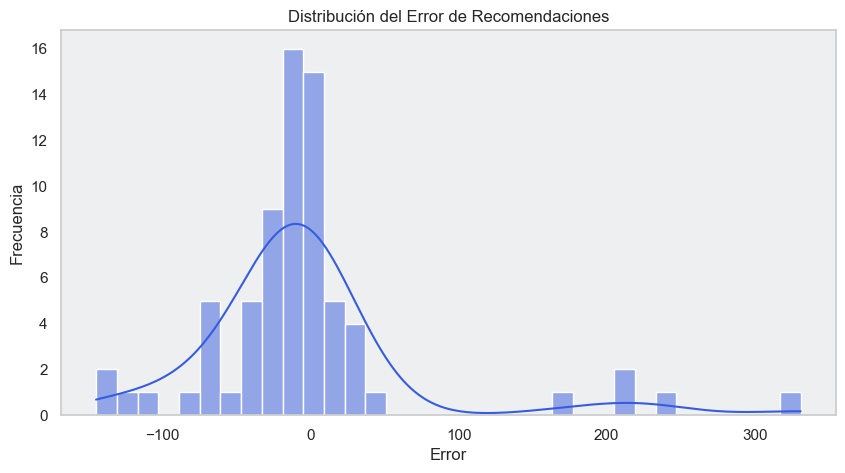

In [281]:
# Histograma de la variable 'Error'
plt.figure(figsize=(10, 5))
sns.histplot(df1['Error'], kde=True, color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

plt.title('Distribución del Error de Recomendaciones')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [110]:
df1['Error'].describe()

count     71.000000
mean      -3.352113
std       76.439724
min     -145.000000
25%      -26.500000
50%      -12.000000
75%        3.000000
max      331.000000
Name: Error, dtype: float64

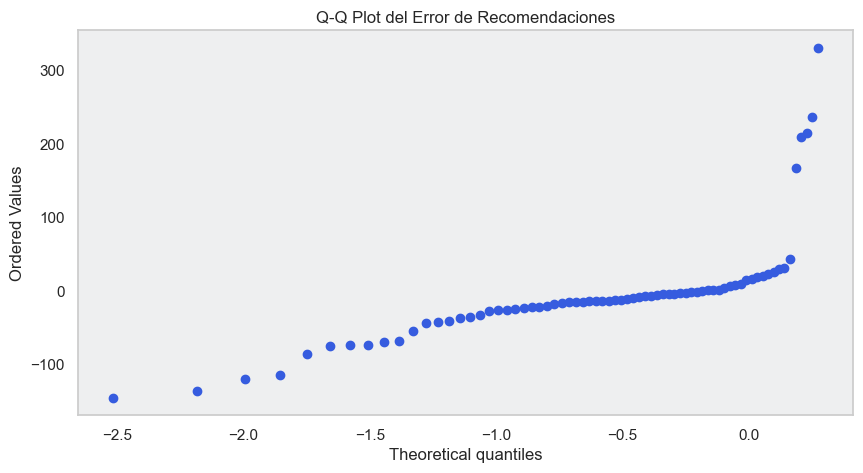

In [111]:
# Q-Q plot para verificar la normalidad de la variable 'Error'
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
stats.probplot(df1['Error'], dist="norm", plot=ax)
ax.get_lines()[0].set_color(color_barras)
ax.get_lines()[1].set_color(color_barras)
ax.title.set_text('Q-Q Plot del Error de Recomendaciones')

# Establecer el color del fondo
ax.set_facecolor(color_fondo)

# Eliminar la cuadricula
ax.grid(False)

plt.show()

- El histograma muestra una concentración de errores alrededor de cero, lo que sugiere que muchas de las recomendaciones estuvieron cerca del número real de clientes del último mes. La media es -3.35 por lo que en general las recomendaciones fueron cercanas a la cantidad de compras que se realizo.
- Sin embargo, la distribución no es simétrica; hay una cola más larga hacia la derecha, indicando errores donde el número de recomendaciones excedió el número de clientes.
- El Q-Q Plot revela que la distribución de errores no sigue una distribución normal, especialmente en los extremos de los cuantiles teóricos. Los datos muestran una desviación sistemática de la línea en el Q-Q Plot.
- Los puntos en el extremo derecho del Q-Q Plot indican la presencia de valores atípicos donde las recomendaciones fueron significativamente mayores que el número de clientes del último mes.

Estos puntos clave sugieren que mientras que el modelo de recomendación es bastante preciso para la mayoría de los productos, hay casos específicos donde las recomendaciones no se alinean bien con el comportamiento real de compra de los clientes. Sería útil investigar más a fondo estos casos atípicos para entender mejor las causas de las discrepancias y ajustar el modelo de recomendación en consecuencia.

#### Producto Estrella

🌟 Hay que tener en cuenta que el producto estrella de la campaña es la Brahma Dorada de 1 litro

Se normaliza la variable para que represente un ranking verdadero según la posición del ranking del producto estrella y la cantidad de recomendaciones que se le hizo a ese cliente. Al normalizar la variable se presentaran los valores en un rango de 0 a 1, siendo 0 el mejor caso y 1 el peor. 

In [2148]:
# Primero, identificamos la posición en el ranking para este producto
df.loc[:, 'es_producto_estrella'] = df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET'

# Luego, contamos el total de recomendaciones por cliente
df.loc[:, 'total_recomendaciones'] = df.groupby('customer_id')['customer_id'].transform('count')

# Finalmente, normalizamos la posición en el ranking del producto estrella
df.loc[:, 'ranking_normalizado'] = None
mask = df['es_producto_estrella']  
df.loc[mask, 'ranking_normalizado'] = df.loc[mask, 'ranking'] / df.loc[mask, 'total_recomendaciones']

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_70866/3207032665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'es_producto_estrella'] = df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET'
/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_70866/3207032665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'total_recomendaciones'] = df.groupby('customer_id')['customer_id'].transform('count')
/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_70866/320

In [2149]:
# Proporción de Recomendaciones del Producto Estrella
recomendaciones_producto_estrella = len(df[df['es_producto_estrella']])
proporcion_recomendaciones_producto_estrella = recomendaciones_producto_estrella / len(df['customer_id'].unique())
print('Proporción de Recomendaciones del Producto Estrella: {:.2f}%'.format(proporcion_recomendaciones_producto_estrella * 100))


Proporción de Recomendaciones del Producto Estrella: 4.01%


Se le recomienda el producto foco de la compañia al 4% de los clientes.
- *Exclusividad en la Recomendación:* El hecho de que solo el 4% de los clientes reciban una recomendación del producto estrella sugiere que el modelo de recomendación considera este producto como una opción más exclusiva o especializada.

- *Potencial de Mercado sin Explotar:* Dado que una pequeña fracción de los clientes ve el producto estrella en sus recomendaciones, podría haber un amplio mercado potencial sin explotar que no está siendo alcanzado por las estrategias actuales.

In [2150]:
# Producto Estrella
df_estrella = df[df['es_producto_estrella']]
df_estrella.head()

,customer_id,product_desc,ranking,brand_family,brand,pack,brand_segment_I,litros,formato,producto,ltrs,es_producto_estrella,total_recomendaciones,ranking_normalizado
15,167627,Brahma Dorada-1 Lts-Bottle-RET,8,Brahma,Brahma Dorada,1 Lts-Bottle-RET,Core,1 Lts,Bottle RET,Dorada,1.0,True,12,0.666667
49,381153,Brahma Dorada-1 Lts-Bottle-RET,1,Brahma,Brahma Dorada,1 Lts-Bottle-RET,Core,1 Lts,Bottle RET,Dorada,1.0,True,2,0.5
74,391158,Brahma Dorada-1 Lts-Bottle-RET,4,Brahma,Brahma Dorada,1 Lts-Bottle-RET,Core,1 Lts,Bottle RET,Dorada,1.0,True,8,0.5
149,447621,Brahma Dorada-1 Lts-Bottle-RET,2,Brahma,Brahma Dorada,1 Lts-Bottle-RET,Core,1 Lts,Bottle RET,Dorada,1.0,True,9,0.222222
501,436980,Brahma Dorada-1 Lts-Bottle-RET,4,Brahma,Brahma Dorada,1 Lts-Bottle-RET,Core,1 Lts,Bottle RET,Dorada,1.0,True,7,0.571429


Se analiza la distribución de los rankings para la Brahma Dorada. Para asi determinar si se la recomienda en posiciones altas o no.

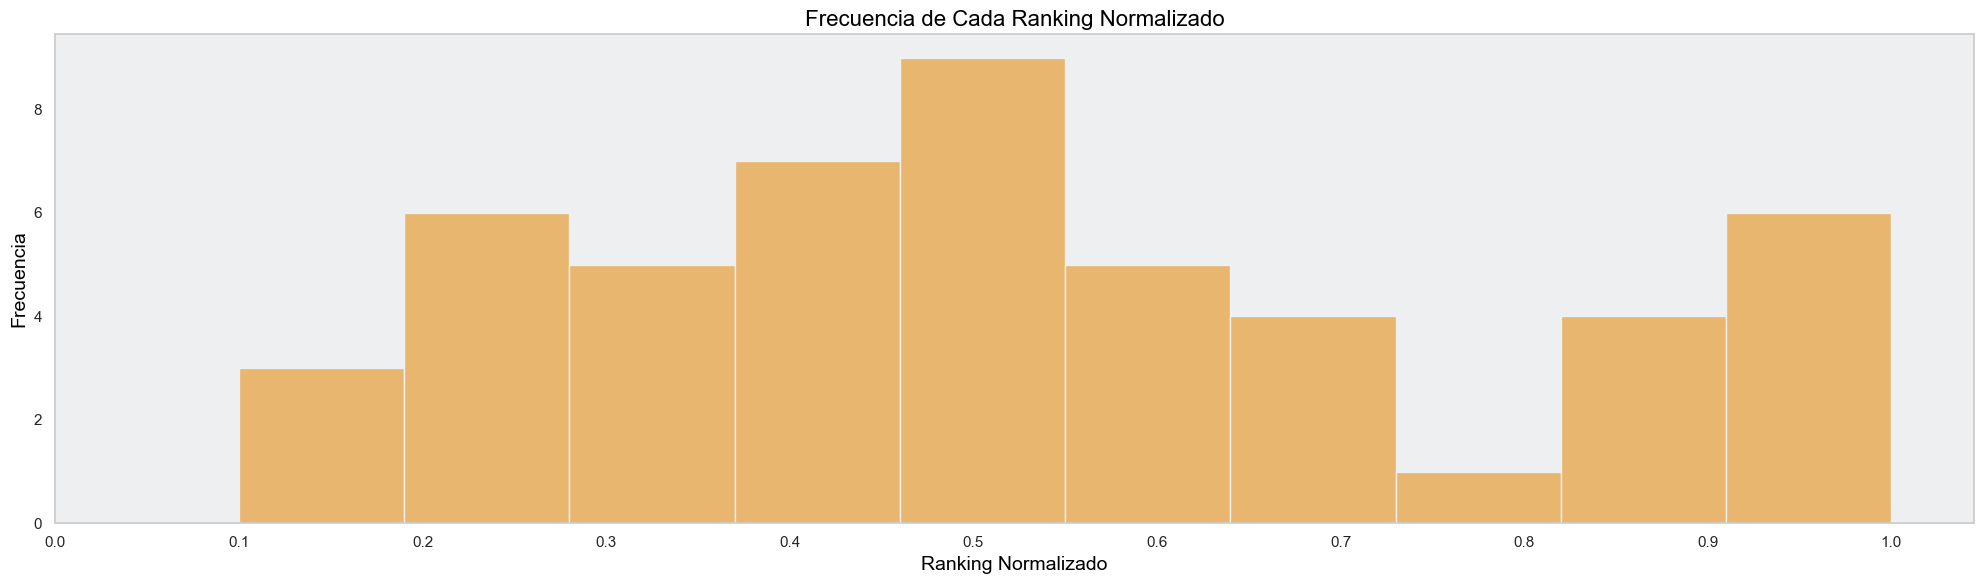

In [2151]:
# Crear el histograma
plt.figure(figsize=(20, 6))
plt.hist(df_estrella['ranking_normalizado'], bins=10, color='#E9B66F', edgecolor=color_fondo)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Ajustar las etiquetas y el título con los colores correspondientes
plt.title('Frecuencia de Cada Ranking Normalizado', fontsize=16, color=color_texto)
plt.xlabel('Ranking Normalizado', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)

# Ajustar los ticks para que coincidan con los rankings enteros
plt.xticks(np.arange(0, 1.1, 0.1))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

- *Concentración en Rankings Menos Prioritarios:* La presencia de frecuencias más altas hacia el extremo derecho del histograma indica que el producto estrella a menudo se encuentra en posiciones menos prioritarias dentro de las recomendaciones realizadas a los clientes.

- *Pocas Recomendaciones de Alta Prioridad:* Las barras más bajas en los rankings normalizados más bajos sugieren que el producto estrella rara vez es una de las opciones más recomendadas o prioritarias.

- *Posible Mejora del Modelo:* El hecho de que el producto estrella se recomiende con frecuencia en posiciones más bajas podría señalar una oportunidad para revisar y posiblemente mejorar cómo el modelo de recomendación valora y clasifica este producto.

- *Variabilidad en las Recomendaciones:* Hay una variabilidad en la posición que el producto estrella ocupa en las recomendaciones, lo que puede reflejar una personalización basada en las preferencias o el comportamiento de compra del cliente.

Este análisis sugiere que el producto estrella podría no estar recibiendo la visibilidad deseada en el modelo de recomendación actual, y se podría trabajar en estrategias para mejorar su clasificación y, en consecuencia, potencialmente aumentar las ventas o la conversión para este producto.

## Aplicación de Restricciones

**Objetivo**: En esta sección, aplicaremos las restricciones específicas del ejercicio a nuestro conjunto de datos. El objetivo es ajustar las recomendaciones actuales de los productos de Quilmes para cumplir con los criterios establecidos, manteniendo la integridad y el equilibrio general de las recomendaciones.

**Procedimiento**: Utilizaremos técnicas de programación y análisis de datos para modificar los objetivos de recomendación. Esto incluirá la implementación de condiciones lógicas y algoritmos que reajusten las recomendaciones de cada producto, asegurándonos de que se cumplan las restricciones de no exceder el 200% ni caer por debajo del 75% de las recomendaciones, mantener el 20% para el segmento premium, y garantizar las recomendaciones mínimas para "Brahma Dorada-1 Lts-Bottle-RET".

#### Restricciones

- **Proporción de recomendaciones sobre clientes del producto**: Debe ser menor a 200% y mayor al 75%.

🤔 *Supuesto:* En el los casos en los que no hay datos de los clientes del ultimo mes, se toma como valor el de las recomendaciones realizadas.

In [2152]:
# Se imputan los valores faltantes de la columna 'customers_last_month' con recomendaciones
df1['customers_last_month'] = df1['customers_last_month'].fillna(df1['recomendaciones'])
df1['Error'] = df1['recomendaciones'] - df1['customers_last_month']

In [2153]:
# Proporción de Recomendaciones de cada Producto
df1['Proporcion'] = df1['recomendaciones'] * 100 / df1['customers_last_month']
df1['Proporcion'].describe()

count    116.000000
mean     100.083715
std       68.226782
min        5.063291
25%       73.453815
50%      100.000000
75%      100.000000
max      560.000000
Name: Proporcion, dtype: float64

El mínimo es 5.06% y el máximo 560% por lo que se exceden los limites en ambos sentidos.

In [2154]:
# Infracciones de la Proporción de Recomendaciones
infracciones = df1[(df1['Proporcion'] > 200) | (df1['Proporcion'] < 75)]

In [2155]:
# Proporción de Infracciones de Recomendaciones
proporcion_infracciones = len(infracciones) / len(df1)
print('Proporción de Infracciones de Recomendaciones: {:.2f}%'.format(proporcion_infracciones * 100))

Proporción de Infracciones de Recomendaciones: 33.62%


In [2156]:
# Exceso de Recomendaciones
exceso = df1[df1['Proporcion'] > 200]
print('Proporcion de Exceso de Recomendaciones: {:.2f}%'.format(len(exceso) / len(df1) * 100))

# Deficit de Recomendaciones
deficit = df1[df1['Proporcion'] < 75]
print('Proporcion de Deficit de Recomendaciones: {:.2f}%'.format(len(deficit) / len(df1) * 100))

Proporcion de Exceso de Recomendaciones: 5.17%
Proporcion de Deficit de Recomendaciones: 28.45%


En el 33.62% de los productos no se cumple la restricción planteada.

- **Segmento Premium**: debe tener al menos el 20% de las recomendaciones totales.

In [2159]:
# Cantidad de recomendaciones por segmento
segmentos = df1.groupby('brand_segment_I')['recomendaciones'].sum().sort_values(ascending=True).reset_index(name='recomendaciones')

In [2160]:
# Proporción de recomendaciones por segmento
segmentos['Proporcion'] = round(segmentos['recomendaciones'] * 100 / segmentos['recomendaciones'].sum(),2)

In [2161]:
# Proporción de recomendaciones para el segmento Premium
prop = segmentos.loc[segmentos['brand_segment_I']=='Premium', 'Proporcion']
print(f"La proporción de recomendaciones para el segmento Premium es: {prop.values[0]}%")

La proporción de recomendaciones para el segmento Premium es: 13.89%


El segmento de productos Premium no cumple la tasa de recomendación planteada del 20% quedando en un 13.89%.

- **Producto Estrella**: debe tener al menos 200 clientes con recomendación.

In [2162]:
# Cantidad de recomendaciones del producto estrella
cant = df1.loc[df1['product_desc']=='Brahma Dorada-1 Lts-Bottle-RET','recomendaciones']
print(f"La cantidad de recomendaciones del producto estrella son: {cant.values[0]}")

La cantidad de recomendaciones del producto estrella son: 50


El producto estrella se le recomienda unicamente a 50 clientes, por lo que no cumple la restricción de tener al menos 200 clientes.

Para automatizar la comprobación de si se cumplen las restricciones una vez definidos nuevos objetivos para cada uno de los productos.

In [2163]:
def comprobar_restricciones(df):
    # Calcular la proporción de recomendaciones sobre clientes
    df['Proporcion'] = df['recomendaciones'] * 100 / df['customers_last_month']

    # Comprobar la restricción de la proporción de recomendaciones
    infracciones = df[(df['Proporcion'] > 200) | (df['Proporcion'] < 75)]

    # Comprobar la restricción del segmento Premium
    segmentos = df.groupby('brand_segment_I')['recomendaciones'].sum()
    porcentaje_premium = segmentos.get('Premium', 0) * 100 / segmentos.sum()

    # Comprobar la restricción del producto estrella
    recomendaciones_producto_estrella = df[df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET']['recomendaciones'].sum()

    # Crear un resumen de las restricciones
    restricciones_cumplidas = {
        'Proporción Recomendaciones/Cientes': len(infracciones) == 0,
        'Segmento Premium': porcentaje_premium >= 20,
        'Producto Estrella': recomendaciones_producto_estrella >= 200
    }

    return restricciones_cumplidas

In [2164]:
# Llamada a la función
restricciones_cumplidas = comprobar_restricciones(df1)
print(restricciones_cumplidas)

{'Proporción Recomendaciones/Cientes': False, 'Segmento Premium': False, 'Producto Estrella': False}


In [2165]:
df1.to_csv('dataAjuste.csv', index=False)

#### Estrategias de Ajuste

Se definirán métodos sistemáticos para modificar las recomendaciones existentes de manera que cumplan con las restricciones dadas. Esto se realiza con el fin de que todas las restricciones estén dentro del rango específico definido.

**Reglas de Reajuste**:
- Para recomendaciones excesivas: Si un producto está siendo recomendado más de lo deseado, se redistribuirán algunas de esas recomendaciones a productos que están siendo recomendados menos.
- Para recomendaciones insuficientes: Si un producto no está alcanzando el umbral mínimo de recomendaciones, se incrementará su frecuencia reduciendo la de otros productos con mayores recomendaciones.
- Mantener el foco en productos clave: El producto foco  "Brahma Dorada-1 Lts-Bottle-RET" y los que sean de segmento Premium deberán tener importancia en las técnicas de reajuste.

**Aspectos a Tener en Cuenta**:
- Pueden ser foco de variación aquellos productos que tengan una variación grande entre las recomendaciones y los clientes que tuvo el mes pasado. Asi se puede lograr obtener normalidad en el error con media 0.
- El número total de recomendaciones no puede ser modificado, pero si la distribución entre productos. Por lo que se debe mantener el numero de recomendaciones totales de 6398.

In [2166]:
# Calculo de número de recomendaciones
recomendaciones_totales = df1['recomendaciones'].sum()
print(f"El número de recomendaciones totales es: {recomendaciones_totales}")

El número de recomendaciones totales es: 6398


In [2168]:
# Convertir a entero la columna 'customers_last_month'
df1['customers_last_month'] = df1['customers_last_month'].astype(int)

#### Se prepara la información para el paso de optimización

In [ ]:
df1.to_csv('dataAjuste.csv', index=False)